# 复仇者联盟4影评分析

## 爬取数据
这里通过去请求猫眼的API来抓取数据，借助的工具是 requests 。
这里简单说下复仇猫眼影评的API：http://m.maoyan.com/mmdb/comments/movie/248172.json?_v_=yes&offset=20
其中，248172 表示猫眼中该电影的id（直接从猫眼官网得到），offset表示偏移量，简单理解就是页数

In [1]:
import requests
import pandas as pd
import numpy as np


base_url = "http://m.maoyan.com/mmdb/comments/movie/248172.json?_v_=yes&offset="

# 爬取每一页的评论
def crawl_one_page_data(url):
    headers = {
    "User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.108 Safari/537.36",
    "Cookie":"_lxsdk_cuid=16a96482527c8-0fcdbaaf7f0efb-f353163-144000-16a96482527c8; _lxsdk=7456B770716011E998B6ADA0FD79DBD3926139E4E42C4E3AADCCAB3843061EEB; __mta=188585239.1557299472129.1557299505817.1557299517739.4"
    }
    response = requests.get(url, headers=headers)
    
    # 页面访问不成功
    if response.status_code == 200:
        return response.json()
    
    return None

# 解析每一个获得的结果
def parse(data):
    result = []
    # 影评数据在 cmts 这个 key 中
    comments = data.get("cmts")
    
    if not comments:
        return None
    
    for cm in comments:
        yield [cm.get("id"), # 影评id
               cm.get("time"), # 影评时间
               cm.get("score"), # 影评得分
               cm.get("cityName"), # 影评城市 
               cm.get("nickName"), # 影评人 
               cm.get("gender"), # 影评人性别，1 表示男性，2表示女性
               cm.get("content")] # 影评内容

# 爬取影评
def crawl_film_review(total_page_num=100):
    data = []
    for i in range(1, total_page_num + 1):
        url = base_url + str(i)
        crawl_data = crawl_one_page_data(url)
        if crawl_data:
            data.extend(parse(crawl_data))
    return data

columns=["id", "time", "score", "city", "nickname", "gender", "content"]
df = pd.DataFrame(crawl_film_review(4000), columns=columns)
# 将性别映射后的数字转为汉字
df["gender"] = np.where(df.gender==1, "男性", "女性")
# 根据id去除重复影评
df = df.drop_duplicates(subset=["id"])
df.head()

,id,time,score,city,nickname,gender,content
0,1065977849,2019-05-08 20:21,5.0,泸州,yyyyyyyy,女性,好看，钢铁侠😭 😭 😭
1,1065980323,2019-05-08 20:21,5.0,福州,Dve849366439,男性,喜欢，可是雷神变雷人了
2,1065978950,2019-05-08 20:20,5.0,北京,buptkuku,男性,赞赞(/≧▽≦/)
3,1065978942,2019-05-08 20:20,5.0,湛江,潮汕人丶,女性,非常好看，完美
4,1065982508,2019-05-08 20:20,5.0,北京,WhP306504301,女性,哭辽想妮妮了


In [2]:
# 保存抓取数据，方便后续使用。
#df.to_csv("复仇者联盟影评_1000.csv", index=False)
# df = pd.read_csv("复仇者联盟影评_1000.csv", encoding="gbk")   如果数据文件名含有中文会出现  OSError: Initializing from file failed
#如果文件中含有中文名则使用以下方法：
#f = open('我的文件.csv')
#res = pd.read_csv(f)

#保存本次所抓取的数据
df.to_csv("复仇者联盟影评_1000.csv", index=False)
f = open("复仇者联盟影评_1000.csv",encoding="UTF-8") 
df = pd.read_csv(f)
df.head()

,id,time,score,city,nickname,gender,content
0,1065977849,2019-05-08 20:21,5.0,泸州,yyyyyyyy,女性,好看，钢铁侠😭 😭 😭
1,1065980323,2019-05-08 20:21,5.0,福州,Dve849366439,男性,喜欢，可是雷神变雷人了
2,1065978950,2019-05-08 20:20,5.0,北京,buptkuku,男性,赞赞(/≧▽≦/)
3,1065978942,2019-05-08 20:20,5.0,湛江,潮汕人丶,女性,非常好看，完美
4,1065982508,2019-05-08 20:20,5.0,北京,WhP306504301,女性,哭辽想妮妮了


## 性别分析

In [3]:
from pyecharts import Pie

# 求出不同性别出现的次数
gender_count = df.gender.value_counts().to_dict()

pie = Pie("性别分析")
pie.add(name="", attr=gender_count.keys(), value=gender_count.values(), is_label_show=True)
pie

## 评分分布

In [4]:
from pyecharts import Bar

# 求出不同评分出现的次数
score_count = df.score.value_counts().sort_index()
score_list = score_count.index.tolist()
count_list = score_count.tolist()

bar = Bar("评分分布", width=450, height=450)
bar.add("", score_list, count_list)
bar

## 不同性别评分的差异

In [5]:
# 求出不同性别评分的均值
sex_score_mean = df.groupby(["gender"])["score"].mean().to_dict()

bar = Bar("不同性别评分的差异", width=450, height=450)

bar.add("", list(sex_score_mean.keys()), list(sex_score_mean.values()), is_stack=True)
bar

## 一线城市与二线城市的评分差异

In [6]:
# 求出不同城市评分的均值

city_list = ["北京", "上海", "合肥", "南宁"]

gender_city_score_mean = df[df.city.isin(city_list)].groupby(["gender", "city"], as_index=False)["score"].mean()

city_data, city_index = pd.factorize(gender_city_score_mean.city)
gender_data, gender_index = pd.factorize(gender_city_score_mean.gender)
data = list(zip(city_data, gender_data, gender_city_score_mean.score.values))

In [7]:
from pyecharts import Bar3D

bar3d = Bar3D("一线城市与二线城市的评分差异", width=650, height=450)

range_color = ['#313695', '#4575b4', '#74add1', '#abd9e9', '#e0f3f8', '#ffffbf',
               '#fee090', '#fdae61', '#f46d43', '#d73027', '#a50026']
bar3d.add("", city_index, gender_index, data,
          is_visualmap=True, visual_range=[0, 5],
          visual_range_color=range_color, grid3d_width=150, grid3d_depth=80, is_grid3d_rotate=False)
bar3d

## 影评词云图
再来看看通过大家的评论能够得到怎么样的云图。

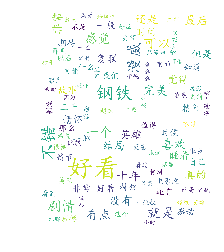

In [16]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import jieba
import matplotlib.pyplot as plt

# 将分词后的结果以空格连接
words = " ".join(jieba.cut(df.content.str.cat(sep=" ")))

# 导入背景图
backgroud_image = plt.imread("格鲁特.jpg")

# 设置停用词
stopwords = STOPWORDS
stopwords.add("电影")

wc = WordCloud(stopwords=stopwords,
               font_path="C:/Windows/Fonts/simkai.ttf",  # 解决显示口字型乱码问题
               mask=backgroud_image, background_color="white", max_words=100)

my_wc = wc.generate_from_text(words)

ImageColorGenerator

image_colors = ImageColorGenerator(backgroud_image)

plt.imshow(my_wc )
# plt.imshow(my_wc.recolor(color_func=image_colors), )
plt.axis("off")
plt.show()